In [ ]:
#importing Libary
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image
from PIL import Image
import torch.optim as optim
import torchvision

In [ ]:
model=models.vgg19(pretrained=True).features
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 83.8MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()

        self.chosen_features = ["0", "5", "10", "19", "28"]
        self.model = models.vgg19(pretrained=True).features[:29]

    def forward(self, x):
        features = []

        for layer_num, layer in enumerate(self.model):
            x = layer(x)

            if str(layer_num) in self.chosen_features:
                features.append(x)

        return features

In [ ]:
VGG()

VGG(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imsize = 356
loader = transforms.Compose(
    [
        transforms.Resize((imsize, imsize)),
        transforms.ToTensor()
    ]
)

In [ ]:
def load_image(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device)

In [ ]:
original_img=load_image("/content/drive/MyDrive/londoncl.jpg")
style_img=load_image("/content/drive/MyDrive/van.jpg")
generated = original_img.clone().requires_grad_(True)

In [ ]:
model = VGG().to(device).eval()

In [ ]:
total_steps = 6000*2
learning_rate = 0.001
alpha = 1
beta = 0.01
optimizer = optim.Adam([generated], lr=learning_rate)

In [ ]:
count=0
for step in range(total_steps):
    # Obtain the convolution features in specifically chosen layers
    generated_features = model(generated)
    original_img_features = model(original_img)
    style_features = model(style_img)

    # Loss is 0 initially
    style_loss = original_loss = 0

    # iterate through all the features for the chosen layers
    for gen_feature, orig_feature, style_feature in zip(
        generated_features, original_img_features, style_features
    ):

        # batch_size will just be 1
        batch_size, channel, height, width = gen_feature.shape
        original_loss += torch.mean((gen_feature - orig_feature) ** 2)
        # Compute Gram Matrix of generated
        G = gen_feature.view(channel, height * width).mm(
            gen_feature.view(channel, height * width).t()
        )
        # Compute Gram Matrix of Style
        A = style_feature.view(channel, height * width).mm(
            style_feature.view(channel, height * width).t()
        )
        style_loss += torch.mean((G - A) ** 2)

    total_loss = alpha * original_loss + beta * style_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if step % 1200 == 0:
        print(total_loss)
        name=str(count)+"ngenerated.png"
        save_image(generated, name)
        count+=1

save_image(generated, "generated.png")

tensor(4175.3052, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1651.1868, device='cuda:0', grad_fn=<AddBackward0>)
tensor(951.2739, device='cuda:0', grad_fn=<AddBackward0>)
tensor(648.1520, device='cuda:0', grad_fn=<AddBackward0>)
tensor(476.5493, device='cuda:0', grad_fn=<AddBackward0>)
tensor(375.4413, device='cuda:0', grad_fn=<AddBackward0>)
tensor(314.3263, device='cuda:0', grad_fn=<AddBackward0>)
tensor(277.1529, device='cuda:0', grad_fn=<AddBackward0>)
tensor(255.9311, device='cuda:0', grad_fn=<AddBackward0>)
tensor(242.7883, device='cuda:0', grad_fn=<AddBackward0>)


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for i in range(3):
        fig, ax = plt.subplots(figsize=(5, 10))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(dl[i]).permute(1, 2, 0))

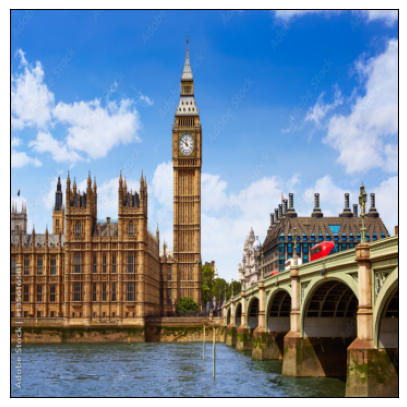

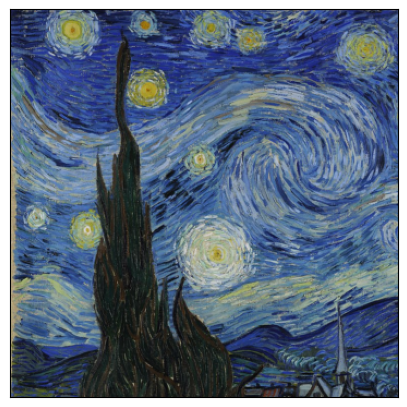

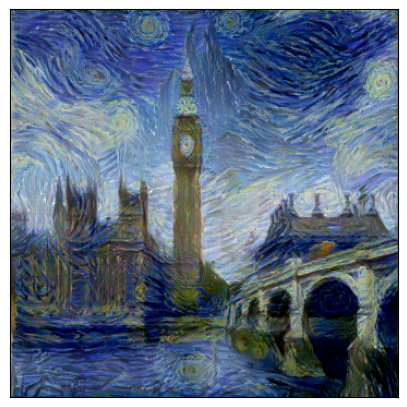

In [ ]:
main = Image.open('/content/drive/MyDrive/images.jpeg')
style = Image.open('/content/drive/MyDrive/van.jpg')
res = Image.open('/content/generated.png')
images_2=[main,style,res]
images=[original_img.to('cpu'),style_img.to('cpu'),generated.to('cpu').detach()]
show_batch(images)